In [1]:
import os
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
def random_rotation(img): # called in images_random_affine
    # Choose a random angle from -10 to -5 or 5 to 10 degrees
    if random.random() > 0.5:
        angle = random.uniform(-10, -5)
    else:
        angle = random.uniform(5, 10)
    return TF.rotate(img, angle)

# Définir la transformation des données, à la fois pour convenir au ResNet ("Resize(224)")
# et pour augmenter le dataset tout en l'équilibrant
data_transforms = {
    'original_images': transforms.Compose([
        # Suppression du bandeau vertical sur les images originelles
        transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Data augmentation techniques,
    'images_horizontally_flipped': transforms.Compose([
        transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
        transforms.RandomHorizontalFlip(1),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_affine': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top=0, left=0, height=img.height - 32, width=img.width)),
    transforms.Lambda(random_rotation),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_perspective': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Utiliser un GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chemins vers le dataset
data_dir_training = 'Dataset\Dataset\Training_data'
data_dir_testing = 'Dataset\Dataset\Testing_data'

In [10]:
animal_classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']

# Do only resizing and normalization
def create_non_augmented_images(data_dir, transform):
    transformed_images = []
    for class_name in animal_classes:
        print(class_name)
        for img in os.listdir(os.path.join(data_dir, class_name)):
            img_path = os.path.join(data_dir, class_name, img)
            image = Image.open(img_path)
            resized_img = transform(image)
            transformed_images.append((resized_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
original_training_dataset = create_non_augmented_images(data_dir_training, data_transforms['original_images'])
original_testing_dataset = create_non_augmented_images(data_dir_testing, data_transforms['original_images'])

badger
bird
cat
fox
mouse
rabbit
badger
bird
cat
fox
mouse
rabbit


In [31]:
class_occurences_training_initial = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in original_training_dataset:
    class_occurences_training_initial[str(img[1])] += 1
    
class_occurences_testing = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in original_testing_dataset:
    class_occurences_testing[str(img[1])] += 1

In [32]:
class_occurences_training_initial

{'badger': 1089,
 'bird': 1070,
 'cat': 758,
 'fox': 1885,
 'mouse': 399,
 'rabbit': 657}

In [15]:
class_occurences_testing

{'badger': 460,
 'bird': 458,
 'cat': 325,
 'fox': 808,
 'mouse': 171,
 'rabbit': 281}

## Data augmentation

We don't have plenty of data, and especially for certain classes (unbalanced dataset). 

In order to correct that, we thought of **data augmentation**. This could solve both issues. 

*Data quantity* : data augmentation can increase the number of data available for training, enabling better learning and generalization.

*Unbalanced dataset* : by augmenting more frequently under-represented classes, this would also enable us to balance the dataset. 

**Augmented images need to be only used during training**.


In [30]:
class_occurences_max = max(class_occurences_training.values())

class_augmentation_probabilities= {
animal: min(1, (class_occurences_max - class_occurences_training[animal]) / (3 * class_occurences_training[animal]))
    for animal in animal_classes
}

images_to_horizontally_flip = {}
images_to_random_affine = {}
images_to_random_perspective = {}

for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_horizontally_flip[class_name] = class_images

for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_random_affine[class_name] = class_images
    
for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_random_perspective[class_name] = class_images

# Now, create datasets for each transformation with filtered images
def create_transformed_dataset(transform, images_list):
    transformed_images = []
    for class_name, images in images_list.items():
        print(class_name)
        for img in images:
            img_path = os.path.join(data_dir_training, class_name, img)
            image = Image.open(img_path)  # Load the image
            transformed_img = transform(image)
            transformed_images.append((transformed_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
horizontal_flip_dataset = create_transformed_dataset(data_transforms['images_horizontally_flipped'], images_to_horizontally_flip)
print("horizontal OK")
affine_transform_dataset = create_transformed_dataset(data_transforms['images_random_affine'], images_to_random_affine)
print("affine OK")
perspective_transform_dataset = create_transformed_dataset(data_transforms['images_random_perspective'], images_to_random_perspective)

badger
bird
cat
fox
mouse
rabbit
horizontal OK
badger
bird
cat
fox
mouse
rabbit
affine OK
badger
bird
cat
fox
mouse
rabbit


In [42]:
# Function to convert a tensor to a PIL image
def tensor_to_pil(tensor):
    # Inverse normalization of the image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    # Inverse normalization of the tensor
    inv_tensor = inv_normalize(tensor)
    # Clamp the image data to valid range (0-1)
    inv_tensor = inv_tensor.clamp(0, 1)
    # Convert to PIL Image
    pil_image = transforms.ToPILImage()(inv_tensor)
    return pil_image

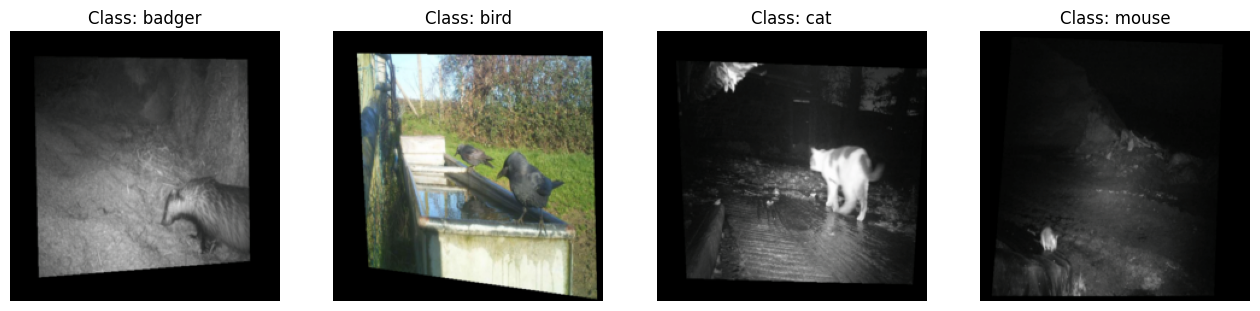

In [79]:
num_images = 4

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))

for i in range(num_images):
    image_tensor, class_name = perspective_transform_dataset[400*i] 
    image_pil = tensor_to_pil(image_tensor)
    # Plot each image
    ax = axes[i]
    ax.imshow(image_pil)
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')

plt.show()

In [33]:
combined_dataset = original_training_dataset + horizontal_flip_dataset + affine_transform_dataset + perspective_transform_dataset

In [41]:
print("non-transformed images: ", len(original_training_dataset))
print("horizontal-flip images: ", len(horizontal_flip_dataset))
print('random affine images: ', len(affine_transform_dataset))
print('random persp images: ', len(perspective_transform_dataset))

non-transformed images:  5858
horizontal-flip images:  1722
random affine images:  1677
random persp images:  1774


In [36]:
class_occurences_training_augmented = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in combined_dataset:
    class_occurences_training_augmented[str(img[1])] += 1

In [37]:
class_occurences_training_augmented

{'badger': 1899,
 'bird': 1875,
 'cat': 1892,
 'fox': 1885,
 'mouse': 1596,
 'rabbit': 1884}